# Dump

For partial attempts.

In [ ]:

LH_salience = pm.Deterministic("LH_salience", pt.mean(pt.exp(pt.sum(logp_obs_salience))))
LH_uniform = pm.Deterministic("LH_uniform", pt.mean(pt.exp(pt.sum(logp_obs_uniform))))

BF = pm.Deterministic("BF", LH_uniform / LH_salience)

prior_predictive.prior.BF.stack(samples=("chain","draw")).mean()

#### Hierarchical Modeling for Bayes Factor Computation

It is possible to reframe the problem as a latent-mixture model. We can assume that there are two different data generating processes, one under $M_1$ and the other under $M_2$. Then, we can assign an indicator parameter that controls the model that generates the data.

The posterior expectation of indicator parameter and the Bayes factor are related. We assume a prior distribution on the indicator parameter which corresponds to prior odds. Then, the posterior expectation of $z$ estimates the posterior odds. So, we can use the ratio between the posterior and the prior to estimate Bayes factor.

This translates to the scalar implicature example as follows: there are four possible utterances that can be used to describe three different objects. So for the state prior based on the salience: the $k=3$ and $n=71+139+30=240$.


This index parameter can be modeled as a categorical distribution with number of models as different categories. Intuitively, this indicator parameter jumps between these models during sampling. The time spent sampling each model is proportional to posterior distribution of each model.

There are some practical problems with this approach: (Martin, 2024)
- the less likely model is undersampled, can lead to inaccuracies
- using the same parameter set for more than one model leads to updating even when different models are used: in the case of vague priors the previously accepted values can be very different, leading to sample rejection

These problems can be overcome: (Martin, 2024)
- select a prior that favors the possibly-losing one, so that samples are more likely to be equally from each model, this won't change the result
- we can artificially constrain parameters when the model they belong to is not selected, these are called pseudo priors

In [ ]:
with pm.Model() as m_RSA_comparison:
    
    # state priors from data
    p_s = pm.Data(
        'p_s',
        state_prior,
        dims=('s')
    )

    # L0 as data
    # with uniform state priors
    L0_uniform = pm.Data(
        'L0_uniform',
        l0,
        dims=('u', 's')
    )

    # with experimentally-determined state priors
    L0_empirical = pm.Data("L0_empirical", l0_2, dims=("u", "s"))

    # indicator variable
    phi = pm.Dirichlet("phi", [1, 1])
    z = pm.Multinomial("z", n=1, p=phi)

    # switch based on indicator variable
    L0 = pt.switch(pt.lt(z, 0.5), L0_uniform, L0_empirical)

    # prior for alpha
    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0.01,
        upper=10
    )

    # prior for cost term
    c = pm.Uniform(
        'c',
        lower=-4,
        upper=4
    )

    # P_S1(u|P_L0)
    # now with cost terms
    S1 = pm.Deterministic(
        'S1',
        normalize(
            pt.exp(
                alpha * (pt.log(L0+0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0
        ),
        dims=('u', 's')
    )

    L1 =  pm.Deterministic(
            'L1',
            normalize(
                S1 * p_s,
                1
            ),
            dims=('u', 's')
        )
    
    # u: blue, green, square, circle
    # o: blue square, blue circle, green square

    # P(s|u)
    # we observe for two utterances (blue and square)
    # counts on 3 different referents
    # we need 3 probability values for two utterances
    comprehension = pm.Multinomial(
        "comp", n=180, p=L1[[0, 2], :], observed=np.array([[115, 65, 0],
                                                           [62, 1, 117]])
    )


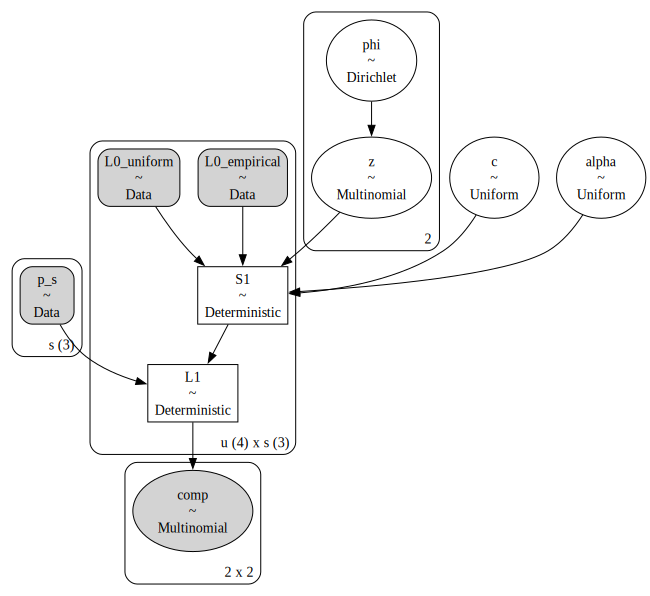

In [ ]:
pm.model_to_graphviz(m_RSA_comparison)

In [ ]:
with m_RSA_comparison:
    idata_comparison = pm.sample(draws=10_000, tune=2000)

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'c'}>],
      dtype=object)

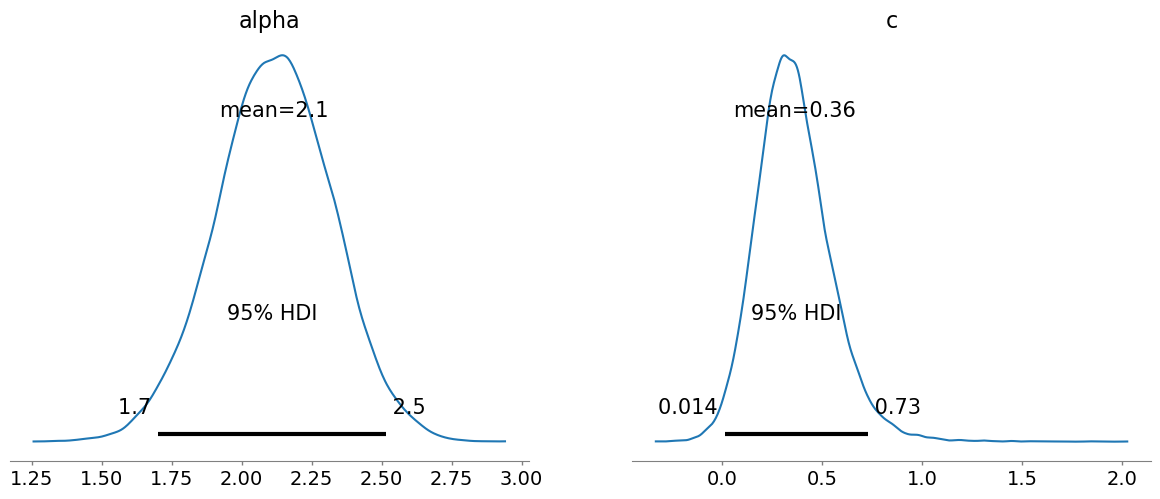

In [ ]:
az.plot_posterior(idata_comparison, var_names=['alpha', 'c'], hdi_prob=0.95)

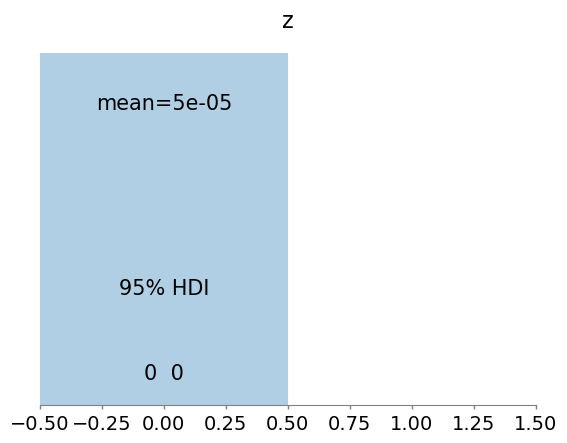

In [ ]:
az.plot_posterior(idata_comparison, var_names=['z'], hdi_prob=0.95);

In [ ]:
iv = idata_comparison.posterior['z'].mean().item()  # mean value of model indicator variable
iv

5e-05

In [ ]:
print(f'Posterior: p(model 1|data) = {1/iv:.2f}')

Posterior: p(model 1|data) = 20000.00


In [ ]:
with pm.Model() as m_RSA_comparison:

    # state priors from data
    p_s = pm.Data("p_s", state_prior, dims=("s"))

    # L0 as data
    # with uniform state priors
    L0_uniform = pm.Data("L0_uniform", l0, dims=("u", "s"))
    # with experimentally-determined state priors
    L0_empirical = pm.Data("L0_empirical", l0_2, dims=("u", "s"))

    # indicator variable
    z = pm.Bernoulli("z", p=0.99)

    # M1 (with uniform priors for L0)
    
    # prior for alpha
    # >= 0
    alpha_m1_true = pm.Uniform("alpha_m1_true", lower=0.01, upper=10)
    # psuedo 
    alpha_m1_pseudo = 1
    
    # prior for cost term
    c_m1_true = pm.Uniform("c_m1_true", lower=-4, upper=4)
    # psuedo
    c_m1_pseudo = 0

    # switch based on indicator
    alpha_m1 = pt.switch(pt.lt(z, 0.5), alpha_m1_true, alpha_m1_pseudo)
    c_m1 = pt.switch(pt.lt(z, 0.5), c_m1_true, c_m1_pseudo)
    
    # P_S1(u|P_L0)
    # now with cost terms
    S1_m1 = pm.Deterministic(
        "S1_m1",
        normalize(
            pt.exp(
                alpha_m1
                * (pt.log(L0_uniform + 0.0001) - pt.reshape(pt.stack([c_m1, c_m1, 0, 0]), (4, 1)))
            ),
            0,
        ),
        dims=("u", "s"),
    )
    L1_m1 = pm.Deterministic("L1_m1", normalize(S1_m1 * p_s, 1), dims=("u", "s"))

    # M2 (with empirical priors for L0)
    # prior for alpha
    # >= 0
    alpha_m2_true = pm.Uniform("alpha_m2_true", lower=0.01, upper=10)
    # psuedo 
    alpha_m2_pseudo = 1
    
    # prior for cost term
    c_m2_true = pm.Uniform("c_m2_true", lower=-4, upper=4)
    # psuedo
    c_m2_pseudo = 0

    # switch based on indicator
    alpha_m2 = pt.switch(pt.gt(z, 0.5), alpha_m2_true, alpha_m2_pseudo)
    c_m2 = pt.switch(pt.gt(z, 0.5), c_m2_true, c_m2_pseudo)
    
    # P_S1(u|P_L0)
    # now with cost terms
    S1_m2 = pm.Deterministic(
        "S1_m2",
        normalize(
            pt.exp(
                alpha_m2
                * (pt.log(L0_empirical + 0.0001) - pt.reshape(pt.stack([c_m2, c_m2, 0, 0]), (4, 1)))
            ),
            0,
        ),
        dims=("u", "s"),
    )
    L1_m2 = pm.Deterministic("L1_m2", normalize(S1_m2 * p_s, 1), dims=("u", "s"))


    # switch based on indicator variable
    S1 = pt.switch(pt.lt(z, 0.5), S1_m1, S1_m2)
    L1 = pt.switch(pt.lt(z, 0.5), L1_m1, L1_m2)

    # u: blue, green, square, circle
    # o: blue square, blue circle, green square

    # both S1 and L1 are shape (u, s) = (4, 3)

    # P(u|s)
    # we observe for each possible referent
    # counts on 4 different utterances
    # we need 4 probability values for each referent, so we take the transpose
    # production = pm.Multinomial(
    #     "prod",
    #     n=144,
    #     p=S1.T,
    #     observed=np.array([[63, 0, 81, 0], [9, 0, 0, 135], [0, 119, 25, 0]]),
    # )

    # P(s|u)
    # we observe for two utterances (blue and square)
    # counts on 3 different referents
    # we need 3 probability values for two utterances
    comprehension = pm.Multinomial(
        "comp",
        n=180,
        p=L1[[0, 2], :],
        observed=np.array([[115, 65, 0], [62, 1, 117]])
    )

In [ ]:
with pm.Model() as m_RSA_comparison:
    
    # state priors from data
    p_s = pm.Data(
        'p_s',
        state_prior,
        dims=('s')
    )

    # L0 as data
    # with uniform state priors
    L0_uniform = pm.Data(
        'L0_uniform',
        l0,
        dims=('u', 's')
    )

    # with experimentally-determined state priors
    L0_empirical = pm.Data("L0_empirical", l0_2, dims=("u", "s"))

    # indicator variable
    phi = pm.Uniform("phi", 0, 1)
    z = pm.Bernoulli("z", p=phi)

    # switch based on indicator variable
    L0 = pt.switch(pt.lt(z, 0.5), L0_uniform, L0_empirical)

    # prior for alpha
    # >= 0 
    alpha = pm.Uniform(
        'alpha',
        lower=0.01,
        upper=10
    )

    # prior for cost term
    c = pm.Uniform(
        'c',
        lower=-4,
        upper=4
    )

    # P_S1(u|P_L0)
    # now with cost terms
    S1 = pm.Deterministic(
        'S1',
        normalize(
            pt.exp(
                alpha * (pt.log(L0+0.0001) - pt.reshape(pt.stack([c, c, 0, 0]), (4, 1)))
            ),
            0
        ),
        dims=('u', 's')
    )

    L1 =  pm.Deterministic(
            'L1',
            normalize(
                S1 * p_s,
                1
            ),
            dims=('u', 's')
        )
    
    # u: blue, green, square, circle
    # o: blue square, blue circle, green square

    # both S1 and L1 are shape (u, s) = (4, 3)
    
    # P(u|s)
    # we observe for each possible referent
    # counts on 4 different utterances
    # we need 4 probability values for each referent, so we take the transpose
    production = pm.Multinomial(
        "prod", n=144, p=S1.T, observed=np.array([
                                                  [63, 0, 81, 0],
                                                  [9, 0, 0, 135],
                                                  [0, 119, 25, 0]
                                                  ])
    )

    # P(s|u)
    # we observe for two utterances (blue and square)
    # counts on 3 different referents
    # we need 3 probability values for two utterances
    comprehension = pm.Multinomial(
        "comp", n=180, p=L1[[0, 2], :], observed=np.array([[115, 65, 0],
                                                           [62, 1, 117]])
    )


### The Dirichlet - Multinomial Model

The multinomial distribution is a generalization of the binomial distribution. Suppose that our distribution support count data on $k$ different values, observed for $n$ independent trials (i.e. rolling a k-sided die n times). Some terms we use for different cases of $n$ and $k$ values are as follows:

| $k$ | $n$ | name |
| --- | --- | --- |
| $=2$ | $=1$ | Bernoulli |
| $=2$ | $\gt1$ | Binomial |
| $\gt2$ | $=1$ | Categorical (Multinoulli)|
| $\gt2$ | $\gt1$ | Multinomial |
 

This translates to the scalar implicature example as follows: there are four possible utterances that can be used to describe three different objects. So for the state prior based on the salience: the $k=3$ and $n=71+139+30=240$.
